In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from lorenz_data.data_generator import data_generator_sde
from lorenz_data.data_generator import euler_sde
from lorenz_data.data_generator import euler_sde_net
from lorenz_data.data_generator import euler
import sys
import os

In [2]:
sys.path.append("../src")
sys.path.append("../src/onetlib")

In [3]:
import onsagernet as onet

## Stochastic lorenz system

The Lorenz 63 system is a determinisic ODE system:
$$
\begin{aligned}
\frac{dX}{d\tau} & = -\sigma X +\sigma Y\\
\frac{dY}{d\tau} &= -XZ +rX -Y\\
\frac{dZ}{d\tau} &= XY-bZ\\\
\end{aligned}$$

Here we consider the generalization of lorenz 63 system:
$$
\begin{aligned}
dX & = (-\sigma X +\sigma Y)d\tau +A_1 d W_1\\
dY &= (-XZ +rX -Y)d\tau +A_2d W_2\\
dZ &= (XY-bZ)d\tau+ A_3d W_3\\
\end{aligned}$$

$\sigma,r, b,A_1,A_2,A_3$ are parameters and $W_i, i =1,2,3$ are Brownian motion which satisfies $W_i(t)-W_i(s) \sim \mathcal{N}(0,t-s),t>s$.

We choose $\sigma = 10, b = 8/3, r = 16, A_1 = A_2 = A_3 = 1$. 

### Data generation

We want to generalize $N$ snapshots $D = \{(x^{(k)},y^{(k)},h^{(k)}\ )\}_{k=1}^{N}$  ,where  $x^{(k)}$ are points scattered in the state space $\mathbb{R}^3$of the lorenz system.The $N$ datapoints $x^{(k)}$ are used as the input variables of our neural network. $y^{(k)}$ results from the evolution the lorenz system under a small time-step $h^{(k)}>0$, starting at $x^{(k)}$. $N$ datapoints $y^{(k)}$ are used as the output variables accordingly. $x^{(k)}$ are sampled from a distribution $f_0(x)$, and $h^{(k)}$ are sampled from distribution $f_h$. Note that the step size $h^{(k)}$ may not be a constant.

We assume $f_0$ is uniformly distributed over $[-5,5]^3$, and $h$ equals to the constant $0.005$.


In [4]:
sigma = 10.
b = 8.0/3.0
r = 16.
a1 = 1.
a2 = 1.
a3 = 1.

# only consider time-homogeneous sde systems
# Any non-timehomogeneous sde system can be transformed 
# into a time-homogeneous system by adding another variable   
def drift(u):
    return np.array([-sigma*u[0]+sigma*u[1],
                    -u[0]*u[2]+r*u[0]-u[1],
                    u[0]*u[1]-b*u[2]])


def diffusitivity(u):
    return np.array([[a1,0,0],[0,a2,0],[0,0,a3]])

In [5]:
tf.random.set_seed(1)
n_samples = 1000*100
n_dim = 3
delta_t = 0.005

X_data = tf.random.uniform(shape = (n_samples,n_dim),minval = -5, maxval = 5)
h = tf.ones((n_samples,1))*0.005

Data_generator = data_generator_sde(drift = drift, diffusitivity = diffusitivity)
Y_data = Data_generator.euler_sde(X_data,h)

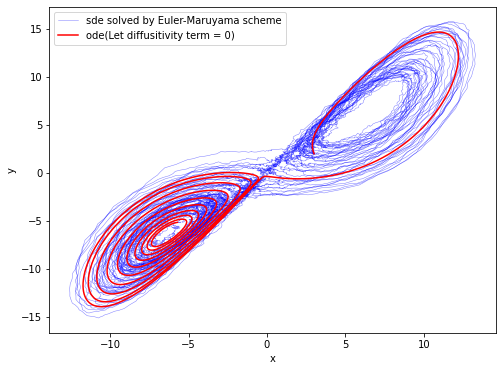

In [6]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)
u0 = np.array([3,2,2])
for i in range(10):
    t,u = euler_sde(drift,diffusitivity,u0 = u0,delta_t = delta_t,N = 2000,n_dim = 3)
    axes.plot(u[:,0],u[:,1],'b',alpha = 0.5,linewidth = 0.5)
t,u = euler_sde(drift,diffusitivity,u0 = u0,delta_t = delta_t,N = 2000,n_dim = 3)
axes.plot(u[:,0],u[:,1],'b',linewidth = 0.5,alpha = 0.5,label = 'sde solved by Euler-Maruyama scheme')
t,u = euler(drift,u0 = u0, t_span = (0,10),N = 100000,n_dim = 3)
axes.plot(u[:,0],u[:,1],'r',label = 'ode(Let diffusitivity term = 0)')
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.legend()
plt.show()

In [7]:
np.savez('lorenz_data/Lorenz_sde.npz',X_data = X_data, Y_data  = Y_data)

In [8]:
# Load data
path = 'lorenz_data/Lorenz_sde.npz'
with np.load(path) as data:
    X_data = data['X_data']
    Y_data = data['Y_data']

In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(
    np.array(X_data),np.array(Y_data),test_size=0.3,shuffle = True
)   

## Build model

In [10]:
beta = 0.1
alpha = 0.01
n_features = 3

pot_layer_size = [16,16,4,4]
dc_layer_sizes = [16,16,4]
fc_layer_sizes = [16,16,4,4]
diffu_layer_sizes = [9,9,9,9]

In [11]:
# build Onsager net 
def build_onsager_net():
    potential_net = onet.FCPotentialNet(beta = beta,
                                       layer_sizes = pot_layer_size,
                                       n_pot = n_features)
    dissconv_net = onet.FCDissConsNet(n_dim = n_features,
                                     layer_sizes = dc_layer_sizes)
    forcing_net = onet.FCForcingNet(n_dim = n_features,layer_sizes = fc_layer_sizes)
    onsager_net = onet.OnsagerNet(n_dim = n_features,
                                  potential_net = potential_net,
                                  dissconv_net = dissconv_net,
                                  forcing_net = forcing_net,
                                  alpha = alpha)
    diffusitivitynet = onet.DiffusitivityNet(n_dim = n_features,layer_sizes = diffu_layer_sizes)
    
    inputs = tf.keras.Input((n_features,))
    outputs = tf.concat([inputs,onsager_net(inputs),diffusitivitynet(inputs)],1)
    
    onsager_rhs = tf.keras.Model(inputs,outputs,name = 'onsager_rhs')
    return onsager_rhs

In [12]:
model = onet.SDEOnsagerNet(n_features = n_features,delta_t = delta_t, OnsagerNet = build_onsager_net())
model.build(input_shape = (None,n_features))
model.summary()

Model: "sde_onsager_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 onsager_rhs (Functional)    (None, 15)                1723      
                                                                 
Total params: 1,723
Trainable params: 1,723
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = onet.CustomEulerLoss(epsilon = 1e-4,n_features = n_features,delta_t = delta_t))

Let's have a look at the predicted drift $f(x)$ and diffusitivity $\sigma(x)$ before traing the neural network. Since the stochastic lorenz system's space belong to $\mathbb{R}^3$, its difficult to draw pictures of $f$ and $\sigma$ directly. Instead, we choose 1 trajectory in the phase space:$(x,x+1,-x),x\in [-2,2]$.

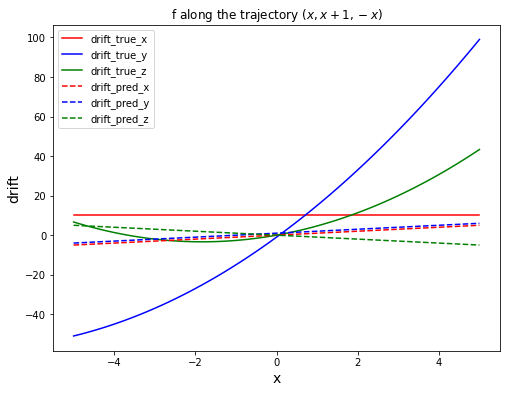

In [14]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)

x = np.linspace(-5,5,100).reshape(-1,1)
xyz = np.concatenate([x,x+1,-x],1)

drift_true = np.apply_along_axis(drift,1,xyz)
axes.plot(x,drift_true[:,0],'r',label = 'drift_true_x')
axes.plot(x,drift_true[:,1],'b',label = 'drift_true_y')
axes.plot(x,drift_true[:,2],'g',label = 'drift_true_z')

pred = model.call(xyz)
drift_pred = pred[:,0:n_features]
axes.plot(x,drift_pred[:,0],'r--',label = 'drift_pred_x')
axes.plot(x,drift_pred[:,1],'b--',label = 'drift_pred_y')
axes.plot(x,drift_pred[:,2],'g--',label = 'drift_pred_z')

axes.set_xlabel('x',fontsize = 14)
axes.set_ylabel('drift',fontsize = 14)
axes.set_title('f along the trajectory $(x,x+1,-x)$')
axes.legend()
plt.show()

We can observe from the picture that the true drift and the predicted drift before training are very different. The true $\sigma$ in the stochastic lorenz system is a 3 dimensional identity matrix. True $\sigma\sigma^T$ is also a 3 dimensonal identity matrix. We can have a look at several predicted $\sigma$ and $\sigma\sigma^T$ befrom training the model.

In [15]:
sigma_pred = pred[:,2*n_features:]
sigma_pred = tf.reshape(sigma_pred,shape = (-1,n_features,n_features))
Sigma = tf.einsum('ijk,ilk->ijl',sigma_pred,sigma_pred)
print('sigma:')
print(sigma_pred[0:3,:,:])
print('\n')
print('sigma*sigma.T:')
print(Sigma[0:3,:,:])

sigma:
tf.Tensor(
[[[-0.37523618 -1.0968137   1.7603172 ]
  [-2.6330853   1.5606157  -3.589132  ]
  [-0.39947298 -1.0314208  -1.1853483 ]]

 [[-0.36532637 -1.0589795   1.7049633 ]
  [-2.5528173   1.5138853  -3.4802794 ]
  [-0.39126518 -0.99757904 -1.1522207 ]]

 [[-0.355372   -1.0208408   1.6491169 ]
  [-2.4719713   1.4668076  -3.3711498 ]
  [-0.3830972  -0.9635633  -1.1189754 ]]], shape=(3, 3, 3), dtype=float32)


sigma*sigma.T:
tf.Tensor(
[[[ 4.442519   -7.0416865  -0.80541563]
  [-7.0416865  22.250528    3.6965666 ]
  [-0.80541563  3.6965666   2.628458  ]]

 [[ 4.161801   -6.6043105  -0.76513886]
  [-6.6043105  20.92107     3.4986587 ]
  [-0.76513886  3.4986587   2.475865  ]]

 [[ 3.8879914  -6.1783276  -0.72553444]
  [-6.1783276  19.626818    3.305877  ]
  [-0.72553444  3.305877    2.3273237 ]]], shape=(3, 3, 3), dtype=float32)


We can see that both the predicted $\sigma$ and $\sigma\sigma^T$ are very far from the identity matrix.

Now let us train the model.

In [16]:
model.evaluate(X_train,Y_train)

2188/2188 [==============================] - 4s 2ms/step - loss: 1658514702336.0000


1658514702336.0

In [17]:
# set learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.4, patience = 2, min_lr = 1e-7)
history = model.fit(x = X_train,
                    y = Y_train,
                    validation_data = (X_test,Y_test),
                    batch_size=64,
                    epochs = 30,
                    callbacks = lr)

Epoch 1/30
1094/1094 [==============================] - 6s 3ms/step - loss: 140037.6875 - val_loss: -2.0941 - lr: 0.0100
Epoch 2/30
1094/1094 [==============================] - 4s 4ms/step - loss: -2.6172 - val_loss: -3.0044 - lr: 0.0100
Epoch 3/30
1094/1094 [==============================] - 5s 4ms/step - loss: -3.2207 - val_loss: -3.3939 - lr: 0.0100
Epoch 4/30
1094/1094 [==============================] - 6s 6ms/step - loss: -3.5098 - val_loss: -3.5988 - lr: 0.0100
Epoch 5/30
1094/1094 [==============================] - 5s 5ms/step - loss: -3.6864 - val_loss: -3.7668 - lr: 0.0100
Epoch 6/30
1094/1094 [==============================] - 6s 6ms/step - loss: -3.9378 - val_loss: -4.1915 - lr: 0.0100
Epoch 7/30
1094/1094 [==============================] - 7s 6ms/step - loss: -4.5498 - val_loss: -4.7211 - lr: 0.0100
Epoch 8/30
1094/1094 [==============================] - 6s 6ms/step - loss: -4.8904 - val_loss: -5.0338 - lr: 0.0100
Epoch 9/30
1094/1094 [==============================] - 6s 6

In [18]:
history = model.fit(x = X_train,
                    y = Y_train,
                    validation_data = (X_test,Y_test),
                    batch_size=64,
                    epochs = 30,
                    callbacks = lr)

Epoch 1/30
1094/1094 [==============================] - 6s 6ms/step - loss: -7.3349 - val_loss: -7.3364 - lr: 0.0040
Epoch 2/30
1094/1094 [==============================] - 6s 6ms/step - loss: -7.3318 - val_loss: -7.3285 - lr: 0.0040
Epoch 3/30
1094/1094 [==============================] - 6s 6ms/step - loss: -7.3341 - val_loss: -7.3403 - lr: 0.0040
Epoch 4/30
1094/1094 [==============================] - 6s 6ms/step - loss: -7.3339 - val_loss: -7.3225 - lr: 0.0040
Epoch 5/30
1094/1094 [==============================] - 6s 5ms/step - loss: -7.3365 - val_loss: -7.3030 - lr: 0.0040
Epoch 6/30
1094/1094 [==============================] - 6s 6ms/step - loss: -7.3556 - val_loss: -7.3348 - lr: 0.0016
Epoch 7/30
1094/1094 [==============================] - 6s 6ms/step - loss: -7.3556 - val_loss: -7.3504 - lr: 0.0016
Epoch 8/30
1094/1094 [==============================] - 6s 6ms/step - loss: -7.3565 - val_loss: -7.3493 - lr: 0.0016
Epoch 9/30
1094/1094 [==============================] - 6s 6ms/s

In [19]:
model.evaluate(X_test,Y_test)

938/938 [==============================] - 3s 3ms/step - loss: -7.3591


-7.359076499938965

Let us have a look at the predicted $f$ and $\sigma$ after training the model. We choose 1 trajectory in the phase space:$(x,x+1,-x),x\in [-2,2]$ again and plot the true and predicted $f$ along the trajectory.

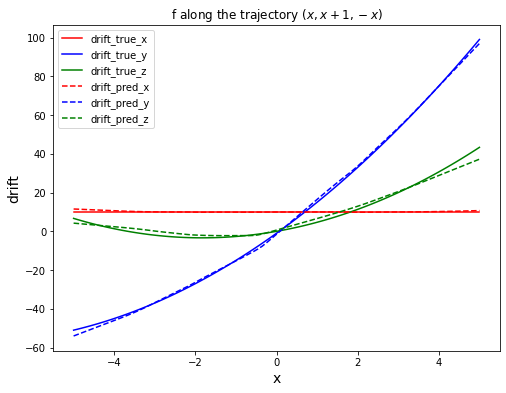

In [22]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)

x = np.linspace(-5,5,100).reshape(-1,1)
xyz = np.concatenate([x,x+1,-x],1)

drift_true = np.apply_along_axis(drift,1,xyz)
axes.plot(x,drift_true[:,0],'r',label = 'drift_true_x')
axes.plot(x,drift_true[:,1],'b',label = 'drift_true_y')
axes.plot(x,drift_true[:,2],'g',label = 'drift_true_z')

pred = model.call(xyz)
drift_pred = pred[:,n_features:2*n_features]
axes.plot(x,drift_pred[:,0],'r--',label = 'drift_pred_x')
axes.plot(x,drift_pred[:,1],'b--',label = 'drift_pred_y')
axes.plot(x,drift_pred[:,2],'g--',label = 'drift_pred_z')

axes.set_xlabel('x',fontsize = 14)
axes.set_ylabel('drift',fontsize = 14)
axes.set_title('f along the trajectory $(x,x+1,-x)$')
axes.legend()
plt.show()

The predicted $f$ and the true $f$ fits rather well.

Then let us have a look at several predicted $\sigma$ and $\sigma\sigma^T$ after training the model.

In [23]:
sigma_pred = pred[:,2*n_features:]
sigma_pred = tf.reshape(sigma_pred,shape = (-1,n_features,n_features))
Sigma = tf.einsum('ijk,ilk->ijl',sigma_pred,sigma_pred)
print('sigma:')
print(sigma_pred[0:3,:,:])
print('\n')
print('sigma*sigma.T:')
print(Sigma[0:3,:,:])

sigma:
tf.Tensor(
[[[-0.07115632 -0.33947223 -0.9373412 ]
  [-0.8790487   0.47295815 -0.10527224]
  [-0.479418   -0.8185988   0.32940704]]

 [[-0.07115632 -0.33947223 -0.9373412 ]
  [-0.8790487   0.47295815 -0.10527224]
  [-0.479418   -0.8185988   0.32940704]]

 [[-0.07115632 -0.33947223 -0.9373412 ]
  [-0.8790487   0.47295815 -0.10527224]
  [-0.479418   -0.8185988   0.32940704]]], shape=(3, 3, 3), dtype=float32)


sigma*sigma.T:
tf.Tensor(
[[[ 9.9891317e-01  6.6973269e-04  3.2384098e-03]
  [ 6.6973269e-04  1.0074984e+00 -4.0861964e-04]
  [ 3.2384098e-03 -4.0861964e-04  1.0084547e+00]]

 [[ 9.9891317e-01  6.6973269e-04  3.2384098e-03]
  [ 6.6973269e-04  1.0074984e+00 -4.0861964e-04]
  [ 3.2384098e-03 -4.0861964e-04  1.0084547e+00]]

 [[ 9.9891317e-01  6.6973269e-04  3.2384098e-03]
  [ 6.6973269e-04  1.0074984e+00 -4.0861964e-04]
  [ 3.2384098e-03 -4.0861964e-04  1.0084547e+00]]], shape=(3, 3, 3), dtype=float32)


We note that **predicted $\sigma$ are not close to identity matrix,** however, **predicted $\sigma \sigma^T$ are quite close to the identity matrix**. We explains this as follows:

For a SDE 
$$d(x_t) = f(x_t)dt+\sigma(x_t)dW_t$$
where $x_t \in \mathbb{R}^n,f:\mathbb{R}^n\rightarrow \mathbb{R}^n,\sigma:\mathbb{R}^n\rightarrow \mathbb{R}^{n \times n}$.
$W_t$ is Brownian motion which satisfies $W_i(t)-W_i(s) \sim \mathcal{N}(0,t-s),t>s$.
Given the value of $x_t = x$ at a time $t$, we want to evaluate the value of $x_{t+h}$ at time $t+h$.  Denote $x_{t+h}$ by $y$. If we use Euler-Maruyama scheme, we can estimate $y$:
$$y = x + hf(x) +\sigma(x) \delta W_t$$
$\delta W_t = [\delta W_t^1,\cdots, \delta W_t^n]$, $\delta W_t^i$ are i.i.d. distributed.
Then $y$ satisfies a normal distribution:
$$y \sim \mathcal{N}(x+hf(x),\Sigma)$$
$$
\begin{aligned}
\Sigma_{ij} &= E[(y_i-\mu_i)(y_j - \mu_j)]\\
&=E[(y_i-x_i-hf_i(x))(y_j-x_j-hf_j(x))]\\
&=E[(\sigma(x)\delta W_t)_i(\sigma(x)\delta W_t)_j]\\
&=E[\Sigma_{k=1,l=1}^n \ \  \sigma_{ik}\delta W_t^k \sigma_{jl} \delta W_t^l]\\
&=\Sigma_{k=1,l=1}^n \sigma_{ik}\sigma_{jl} E[\delta W_t^k \delta W_t^l]\\
&= \Sigma_{k=1}^n \sigma_{ik}\sigma_{jk} E[\delta W_t^k \delta W_t^k]\\
&= \Sigma_{k=1}^n \sigma_{ik}\sigma_{jk}h\\
&= (\sigma\sigma^Th)_{ij}\\
\end{aligned}
$$

So $\Sigma = \sigma\sigma^Th$.

The probability density function of y is :
$$f_\theta(y|x,h) = \frac{1}{\sqrt{(2\pi)^n |det\Sigma|}} exp(-\frac{1}{2}(y-x-f(x)h)^T\Sigma^{-1}(y-x-f(x)h)$$

Where $\theta$ denote the parameters of the neural network, and $n$ is the dimension. We choose the minus loglikelihood as our loss function:
$$\begin{aligned}
\mathcal{L}_{\theta}(y|x,h) &= -2\times log f_{\theta}(y|x,h)\\
&= (y-x-f(x)h)^T)\Sigma^{-1}(y-x-f(x)h) + log|det\Sigma| + nlog(2\pi)
\end{aligned}$$

We note $\sigma$ only appears in the $\Sigma$ and $\Sigma^{T}$. $\Sigma$ and $\Sigma^{-1}$ are in fact functions of $\sigma \sigma^{T}$. As long as predicted $\sigma \sigma^{T}$ is close to the true $\sigma \sigma^{T}$, the loss can be decreased. Hence the $\sigma$ solved by the neural network may not be close to $\sigma$, and our network can only ensure $\sigma \sigma^T$ is close to true one.